# 💰 Optimisation Budgétaire Marketing

Ce notebook optimise l'allocation du budget marketing :
- Calcul du ROI marginal par canal
- Optimisation de l'allocation budgétaire
- Scénarios what-if
- Recommandations actionnables

**Auteur** : Ivan  
**Projet** : MMM Bayésien - MSMIN5IN43

In [1]:
# Imports
import sys
sys.path.insert(0, '../src')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from data.loader import create_sample_data
from models.base_mmm import BayesianMMM
from optimization.budget_allocator import (
    optimize_budget_allocation,
    calculate_marginal_roi,
    compare_scenarios,
    get_optimal_increments,
    calculate_channel_roi
)
from visualization.optimization_plots import (
    plot_budget_comparison,
    plot_marginal_roi,
    plot_budget_scenarios,
    plot_incremental_allocation,
    plot_channel_roi_comparison
)
from visualization.contribution import calculate_channel_contributions

# Config
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)
%matplotlib inline

np.random.seed(42)

## 1️⃣ Préparer les données et le modèle

In [2]:
# Générer données
df = create_sample_data(n_periods=80, n_media_channels=3, seed=42)

media_cols = ['media_1_spend', 'media_2_spend', 'media_3_spend']
channel_names = ['TV', 'Facebook', 'Google Ads']

X_media = df[media_cols].values
y = np.log1p(df['sales'].values)

print(f"✓ Données: {len(df)} périodes")
print(f"✓ Canaux: {channel_names}")

✓ Données: 80 périodes
✓ Canaux: ['TV', 'Facebook', 'Google Ads']


In [3]:
# Entraîner le modèle
print("🔨 Entraînement du modèle...\n")

mmm = BayesianMMM(use_adstock=True, use_saturation=True)

alpha = np.array([0.5, 0.6, 0.4])
k = X_media.mean(axis=0)
s = np.array([1.0, 1.0, 1.0])

trace = mmm.fit(
    X_media, y,
    alpha=alpha, k=k, s=s,
    draws=1000, tune=1000, chains=2,
    random_seed=42
)

print("✅ Modèle entraîné")

Initializing NUTS using jitter+adapt_diag...


🔨 Entraînement du modèle...



Multiprocess sampling (2 chains in 2 jobs)
NUTS: [intercept, beta_media, sigma]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 4 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics


✅ Modèle entraîné


In [4]:
# Extraire les coefficients
coefficients = trace.posterior['beta_media'].mean(dim=['chain', 'draw']).values

print("📊 Coefficients estimés:")
for name, coef in zip(channel_names, coefficients):
    print(f"  {name:15s}: {coef:.4f}")

📊 Coefficients estimés:
  TV             : 0.5060
  Facebook       : 0.5216
  Google Ads     : 0.1943


## 2️⃣ Dépenses actuelles et contributions

In [5]:
# Dépenses moyennes actuelles
current_spend = X_media.mean(axis=0)
total_budget = current_spend.sum()

print(f"💰 Budget actuel: {total_budget:.0f}€/période")
print("\n📊 Répartition actuelle:")
for name, spend in zip(channel_names, current_spend):
    pct = (spend / total_budget) * 100
    print(f"  {name:15s}: {spend:6.0f}€ ({pct:5.1f}%)")

💰 Budget actuel: 344€/période

📊 Répartition actuelle:
  TV             :    105€ ( 30.5%)
  Facebook       :    172€ ( 49.9%)
  Google Ads     :     67€ ( 19.6%)


In [6]:
# Contributions aux ventes
X_transformed = mmm.apply_transformations(X_media, alpha, k, s)
contributions = calculate_channel_contributions(trace, X_transformed, channel_names)

print("\n💡 Contributions aux ventes:")
print(contributions[['channel', 'pct_total']].to_string(index=False))


💡 Contributions aux ventes:
   channel  pct_total
  Facebook  42.744352
        TV  41.353100
Google Ads  15.902548


In [7]:
# ROI actuel par canal
X_trans_mean = X_transformed.mean(axis=0)
sales_contrib = X_trans_mean * coefficients

roi_current = calculate_channel_roi(current_spend, sales_contrib)

print("\n📈 ROI actuel par canal:")
for name, roi in zip(channel_names, roi_current):
    print(f"  {name:15s}: {roi:.2f} ({roi*100:+.0f}%)")


📈 ROI actuel par canal:
  TV             : -1.00 (-100%)
  Facebook       : -1.00 (-100%)
  Google Ads     : -1.00 (-100%)


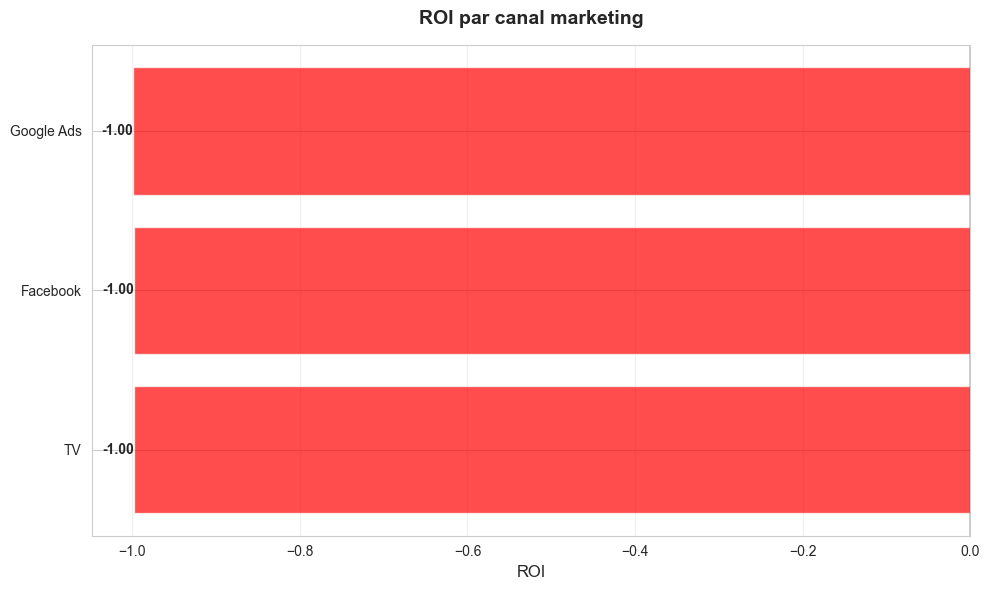

In [8]:
# Visualisation ROI
fig = plot_channel_roi_comparison(channel_names, roi_current)
plt.show()

## 3️⃣ ROI Marginal

In [9]:
# Calculer ROI marginal actuel
marginal_roi = calculate_marginal_roi(
    current_spend,
    coefficients,
    alpha, k, s,
    delta=10.0
)

print("💸 ROI Marginal (pour 10€ supplémentaires):")
for name, mroi in zip(channel_names, marginal_roi):
    print(f"  {name:15s}: +{mroi:.2f} ventes par €")

💸 ROI Marginal (pour 10€ supplémentaires):
  TV             : +0.00 ventes par €
  Facebook       : +0.00 ventes par €
  Google Ads     : +0.00 ventes par €


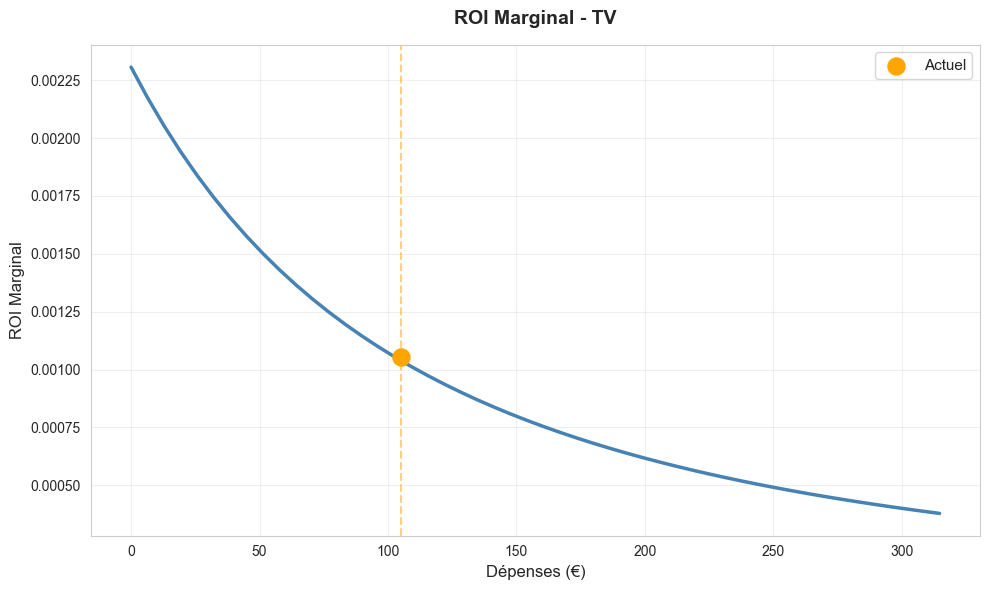

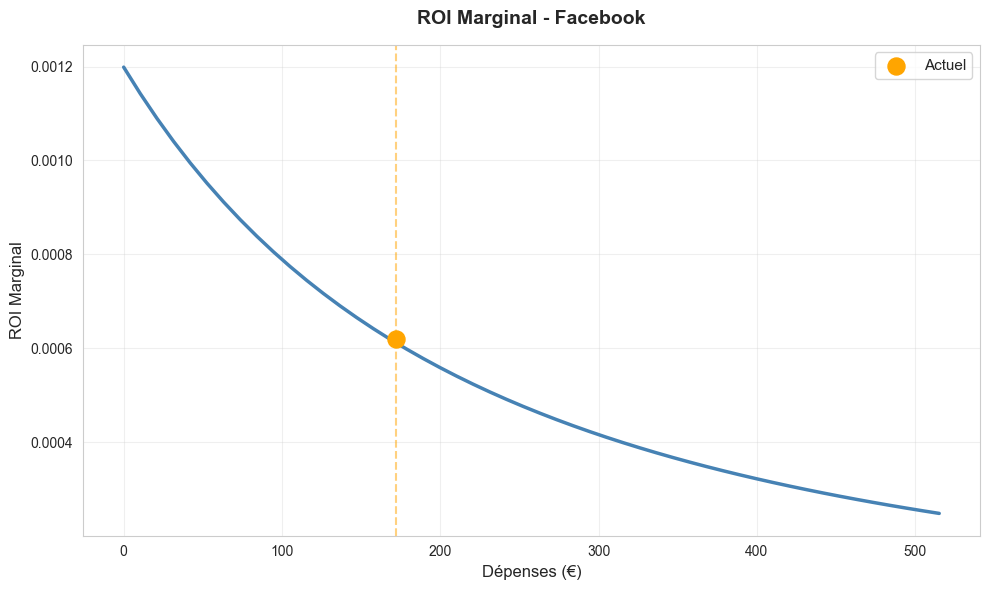

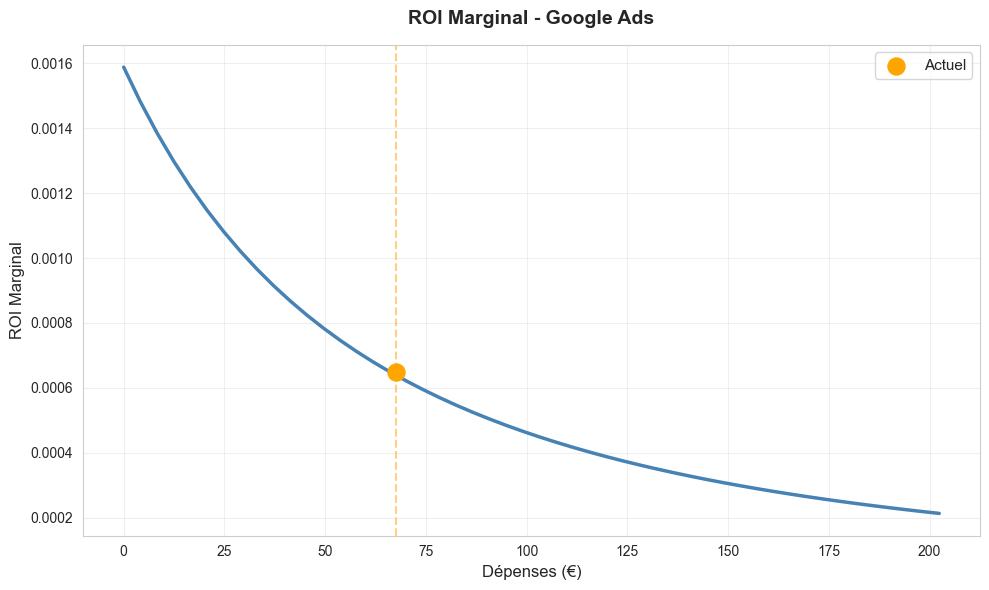

In [10]:
# Courbes de ROI marginal pour chaque canal
for i, name in enumerate(channel_names):
    # Plage de dépenses
    spend_min = 0
    spend_max = current_spend[i] * 3
    spend_range = np.linspace(spend_min, spend_max, 50)
    
    # Calculer ROI marginal pour chaque niveau
    mrois = []
    for spend_level in spend_range:
        test_spend = current_spend.copy()
        test_spend[i] = spend_level
        mroi = calculate_marginal_roi(test_spend, coefficients, alpha, k, s, delta=10.0)
        mrois.append(mroi[i])
    
    # Plot
    fig = plot_marginal_roi(
        spend_range,
        np.array(mrois),
        current_spend=current_spend[i],
        channel_name=name
    )
    plt.show()

## 4️⃣ Optimisation de l'allocation

In [11]:
# Optimiser l'allocation avec le même budget total
print(f"🎯 Optimisation pour budget total = {total_budget:.0f}€\n")

result = optimize_budget_allocation(
    total_budget=total_budget,
    coefficients=coefficients,
    alpha=alpha,
    k=k,
    s=s,
    current_spend=current_spend
)

print(f"Succès: {'✅' if result['success'] else '❌'}")
print(f"Message: {result['message']}")

🎯 Optimisation pour budget total = 344€

Succès: ✅
Message: Optimization terminated successfully


In [12]:
# Résultats de l'optimisation
optimal_spend = result['optimal_spend']

print("\n💰 ALLOCATION OPTIMALE:\n")
print("Canal           Actuel    Optimal   Changement")
print("=" * 55)
for i, name in enumerate(channel_names):
    current = current_spend[i]
    optimal = optimal_spend[i]
    change = ((optimal - current) / current * 100)
    print(f"{name:15s} {current:7.0f}€  {optimal:7.0f}€  {change:+6.1f}%")

print("=" * 55)
print(f"Total:          {current_spend.sum():7.0f}€  {optimal_spend.sum():7.0f}€")


💰 ALLOCATION OPTIMALE:

Canal           Actuel    Optimal   Changement
TV                  105€      167€   +58.9%
Facebook            172€      119€   -30.7%
Google Ads           67€       58€   -13.5%
Total:              344€      344€


In [13]:
# Impact sur les ventes
print("\n📈 IMPACT SUR LES VENTES:\n")
print(f"Ventes actuelles:  {result['current_sales']:.2f}")
print(f"Ventes optimales:  {result['optimal_sales']:.2f}")
print(f"Amélioration:      {result['improvement']:.2f}%")


📈 IMPACT SUR LES VENTES:

Ventes actuelles:  0.39
Ventes optimales:  0.40
Amélioration:      3.30%


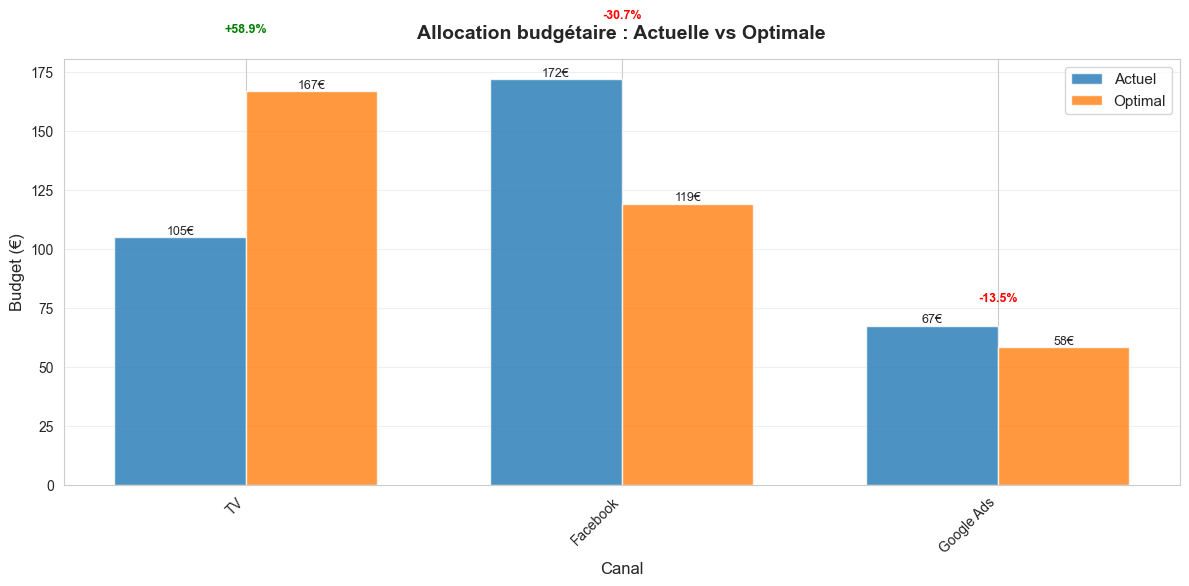

In [14]:
# Visualisation comparaison
fig = plot_budget_comparison(current_spend, optimal_spend, channel_names)
plt.show()

## 5️⃣ Scénarios What-If

In [15]:
# Tester différents budgets
print("🔮 Analyse de scénarios\n")

budgets_to_test = [
    total_budget * 0.5,  # -50%
    total_budget * 0.75, # -25%
    total_budget,        # Actuel
    total_budget * 1.25, # +25%
    total_budget * 1.5   # +50%
]

scenarios = compare_scenarios(
    budgets_to_test,
    coefficients,
    alpha, k, s,
    channel_names
)

print(scenarios.round(2))

🔮 Analyse de scénarios

   budget_total  sales_predicted  roi_overall
0        172.06             0.25          0.0
1        258.09             0.33          0.0
2        344.12             0.40          0.0
3        430.15             0.46          0.0
4        516.18             0.52          0.0


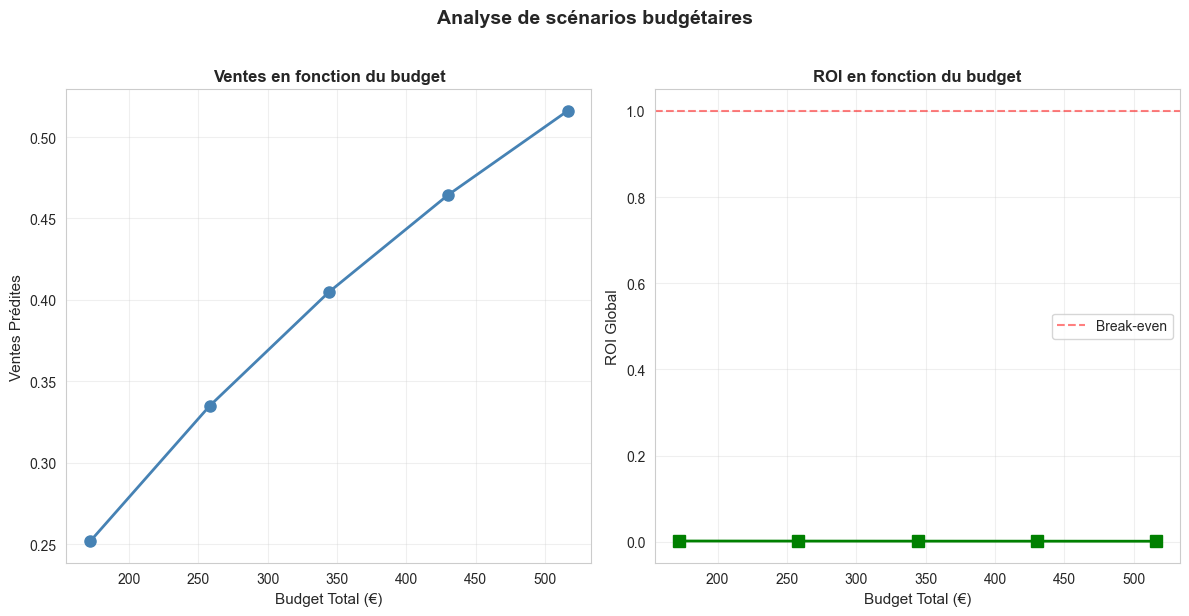

In [16]:
# Visualisation scénarios
fig = plot_budget_scenarios(scenarios)
plt.show()

## 6️⃣ Allocation incrémentale

In [17]:
# Si on a 20% de budget supplémentaire, comment l'allouer ?
additional_budget = total_budget * 0.20

print(f"💡 Allocation optimale de {additional_budget:.0f}€ supplémentaires\n")

increments = get_optimal_increments(
    current_spend,
    additional_budget,
    coefficients,
    alpha, k, s,
    n_steps=10
)

# Résumé par canal
increment_summary = increments.groupby('channel')['increment'].sum()

print("Répartition optimale du budget additionnel:")
for i, amount in increment_summary.items():
    pct = (amount / additional_budget) * 100
    print(f"  {channel_names[i]:15s}: {amount:6.0f}€ ({pct:5.1f}%)")

💡 Allocation optimale de 69€ supplémentaires

Répartition optimale du budget additionnel:
  TV             :     69€ (100.0%)


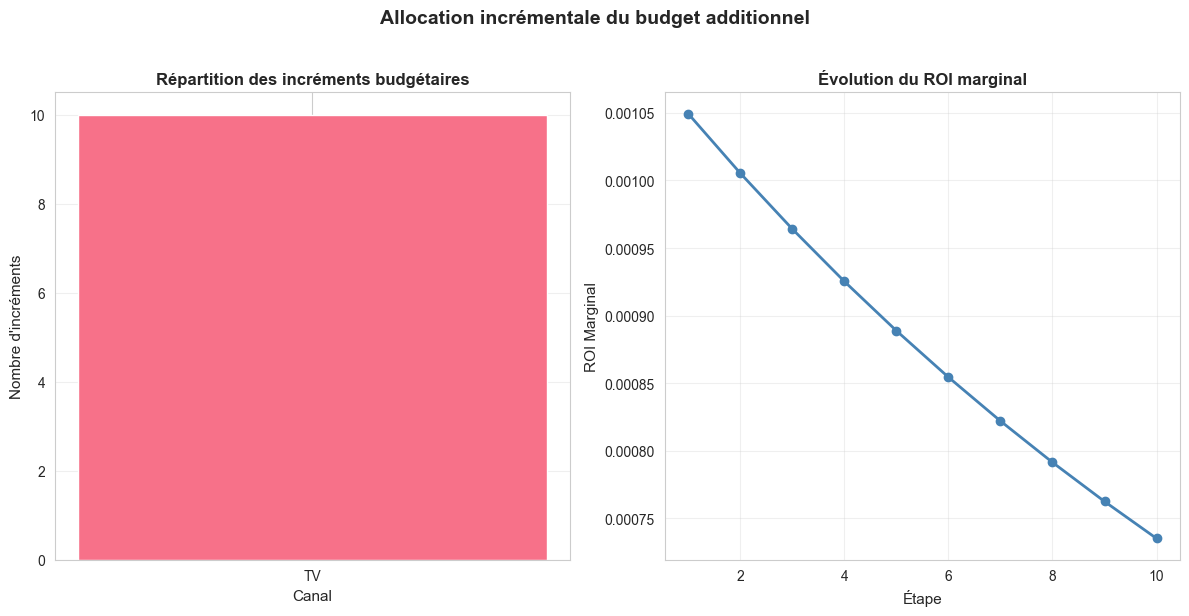

In [18]:
# Visualisation allocation incrémentale
fig = plot_incremental_allocation(increments, channel_names)
plt.show()

## 7️⃣ Recommandations

In [19]:
# Générer recommandations
print("=" * 60)
print("📋 RECOMMANDATIONS STRATÉGIQUES")
print("=" * 60)
print()

# 1. Canaux à augmenter
print("1️⃣ CANAUX À AUGMENTER")
increases = []
for i, name in enumerate(channel_names):
    change = optimal_spend[i] - current_spend[i]
    if change > 0:
        pct = (change / current_spend[i]) * 100
        increases.append((name, change, pct))

increases.sort(key=lambda x: x[1], reverse=True)
for name, change, pct in increases:
    print(f"   ✅ {name}: +{change:.0f}€ ({pct:+.1f}%)")
print()

# 2. Canaux à réduire
print("2️⃣ CANAUX À RÉDUIRE")
decreases = []
for i, name in enumerate(channel_names):
    change = optimal_spend[i] - current_spend[i]
    if change < 0:
        pct = (change / current_spend[i]) * 100
        decreases.append((name, change, pct))

decreases.sort(key=lambda x: x[1])
for name, change, pct in decreases:
    print(f"   ⚠️  {name}: {change:.0f}€ ({pct:.1f}%)")
print()

# 3. Impact global
print("3️⃣ IMPACT ATTENDU")
print(f"   Amélioration des ventes: +{result['improvement']:.2f}%")
print(f"   Sans changement de budget total")
print()

# 4. Plan d'action
print("4️⃣ PLAN D'ACTION")
print("   1. Réallouer le budget selon les recommandations ci-dessus")
print("   2. Monitorer les performances sur 4-6 semaines")
print("   3. Ajuster progressivement si nécessaire")
print("   4. Ré-entraîner le modèle avec nouvelles données")
print()

print("=" * 60)

📋 RECOMMANDATIONS STRATÉGIQUES

1️⃣ CANAUX À AUGMENTER
   ✅ TV: +62€ (+58.9%)

2️⃣ CANAUX À RÉDUIRE
   ⚠️  Facebook: -53€ (-30.7%)
   ⚠️  Google Ads: -9€ (-13.5%)

3️⃣ IMPACT ATTENDU
   Amélioration des ventes: +3.30%
   Sans changement de budget total

4️⃣ PLAN D'ACTION
   1. Réallouer le budget selon les recommandations ci-dessus
   2. Monitorer les performances sur 4-6 semaines
   3. Ajuster progressivement si nécessaire
   4. Ré-entraîner le modèle avec nouvelles données



## 8️⃣ Conclusions

### ✅ Insights clés

1. **Optimisation possible** : Réallocation du budget peut améliorer les ventes sans budget supplémentaire
2. **ROI marginal décroissant** : Chaque euro supplémentaire a un impact de plus en plus faible
3. **Équilibrage optimal** : L'algorithme trouve le point où tous les canaux ont un ROI marginal égal

### 🎯 Prochaines étapes

1. Valider ces recommandations avec l'équipe marketing
2. Mettre en place un test A/B si possible
3. Monitorer les résultats et itérer
4. Automatiser le processus d'optimisation